In [1]:
import numpy as np
import matplotlib.pyplot as plt
import obspy
from obspy import read
from scipy.signal import butter, filtfilt, detrend, hilbert
from scipy.stats import linregress
from datetime import datetime, timedelta
from scipy.io import loadmat
import obspy 
from obspy import read_inventory
import gzip
from mpl_toolkits.basemap import Basemap
import utm
from scipy.io import loadmat

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [2]:
# Define constants

beta = 1250  # S wave velocity; Surface wave velocity in m/s (700-900)
Q = 50  # Attenuation factor
lc, hc = 1, 99  # Low and high cut frequencies (bandpass filter)

# The order here has to match what is in the map file so that positions are correct
stations = ['FEJ1','FEC1','FEC2','FEC4']  # List of stations 

In [3]:
xml = read_inventory(r"C:\Users\jacob\Desktop\Masters Thesis Stuff\Data Files\6Q.xml")

In [4]:
# Read SAC data for a specific station

def read_sac_data(station, MSeedDir,lc,hc):
    """
    Reads the SAC file for a given station and event.

    Parameters:
    - station: station code (string)
    - MSeedDir: directory containing the MSeed files

    Returns:
    - header: header information from the SAC file
    - data: seismic data (numpy array)
    """
    try:
        st = read(f"{MSeedDir}.12.11.6Q.{station}..HHZ.MSEED")
        
        st.resample(sampling_rate=200)
        tr = st[0]  # Assume only one trace per file
        tr.detrend('linear')
        tr.taper(0.05)
        tr.remove_response(inventory=xml)  
        tr.filter('bandpass', freqmin=lc, freqmax=hc, corners=2)
        
        return tr.stats, tr.data
    except FileNotFoundError:
        print(f"No file for {station}")
        return None, None

In [5]:
# Load Geographic Info
A = loadmat(r"C:\Users\jacob\Desktop\Masters Thesis Stuff\Data Files\outputfromReadMapData.mat", variable_names='A')
A  = np.array(A['A'])
x = loadmat(r"C:\Users\jacob\Desktop\Masters Thesis Stuff\Data Files\outputfromReadMapData.mat", variable_names='x')
x  = np.array(x['x'])
y = loadmat(r"C:\Users\jacob\Desktop\Masters Thesis Stuff\Data Files\outputfromReadMapData.mat", variable_names='y')
y  = np.array(y['y'])
sta = loadmat(r"C:\Users\jacob\Desktop\Masters Thesis Stuff\Data Files\outputfromReadMapData.mat", variable_names='sta')
sta  = np.array(sta['sta'])
sta = sta[7:]
sta= sta[0:4,:]

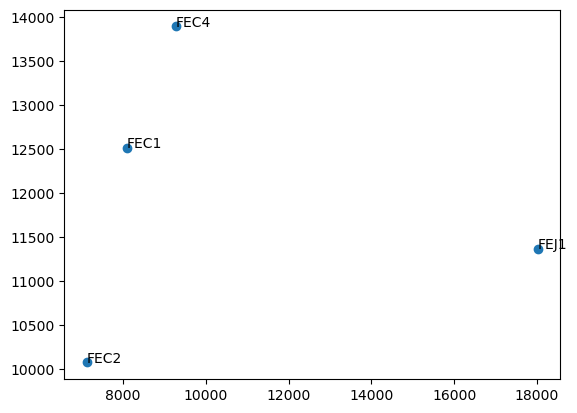

In [6]:
plt.scatter(sta[:,0],sta[:,1])
label=['FEJ1','FEC1','FEC2','FEC4'] # they are actually in this order within the map data
for i in np.arange(sta[:,0].size):
    plt.text(sta[i,0],sta[i,1],label[i])

In [7]:
# Define Start Time Offset and Mseed File Directory

eventstring = r"C:\Users\jacob\Desktop\Masters Thesis Stuff\Data Files\ClipMSEED\2022"  # Placeholder for your event-specific string
MSeedDir = eventstring
tsoffset = 0  

In [8]:
# Create Data Envelope

data_env=np.zeros((2880001,4))

n = 0

for station in stations:
    print("station: {}".format(station))
    header, data = read_sac_data(station, MSeedDir,lc,hc)
    if data is not None:    
#         data_env[0:data.size,n]=np.abs(hilbert(data))
        data_env[0:data.size,n]=data # use amplitudes instead, since we are using the RMS
        n = n+1

station: FEJ1
station: FEC1
station: FEC2
station: FEC4


C:\Users\jacob\anaconda3\envs\obspy\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\jacob\anaconda3\envs\obspy\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


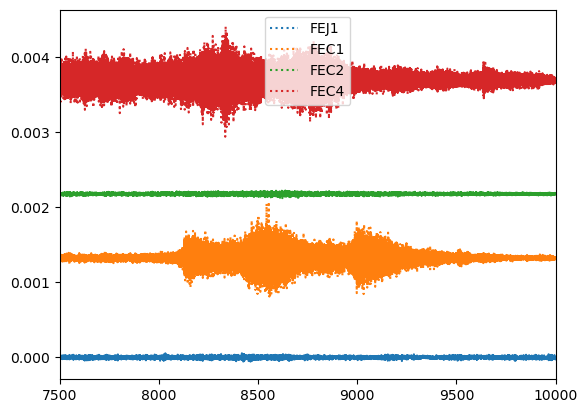

In [9]:
sps=200

label=['FEJ1','FEC1','FEC2','FEC4'] # they are actually in this order within the map data

limits=np.array([7500,10000])
tvec=np.arange(60*sps)/sps
tvec=np.arange(len(data_env[:,1]))/sps
offset=0
for i in np.arange(4):
    if i>0:
        offset+=(data_env[limits[0]*sps:limits[1]*sps,i].max()-data_env[limits[0]*sps:limits[1]*sps,i].min()) + data_env[limits[0]*sps:limits[1]*sps,i-1].max()
    plt.plot(tvec,offset+data_env[:,i],':')

plt.xlim([limits[0],limits[1]])
plt.legend(label)

C:\Users\jacob\AppData\Local\Temp\ipykernel_16108\2112830708.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ampl[j] = np.array([np.sqrt(np.mean( (data_env[int(t1samp[j]):int(t2samp[j]), j])** 2))])


R2: 0.9059603938122872 at  ts 8050
[-11.38295527 -10.61259533 -11.62546981  -9.09652175]
[-11.85682171 -10.51673629 -11.26100709  -9.08297707]
[-0.47386644  0.09585904  0.36446272  0.01354468]
0.36675488829123615


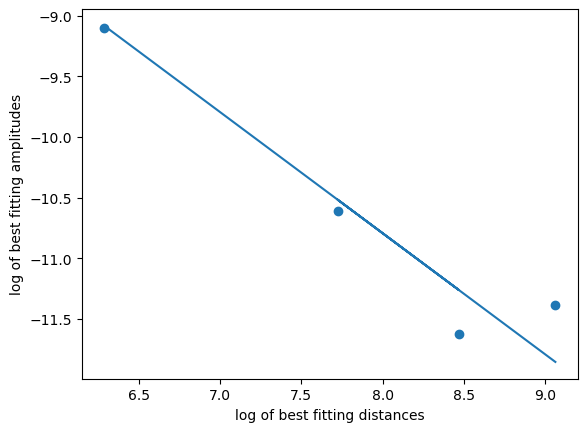

R2: 0.908542715344212 at  ts 8050
[-11.38147961 -10.61225838 -11.62442387  -9.09696947]
[-11.79465822 -10.4988918  -11.22185659  -9.19972472]
[-0.41317861  0.11336658  0.40256728 -0.10275524]
0.35618759639361713


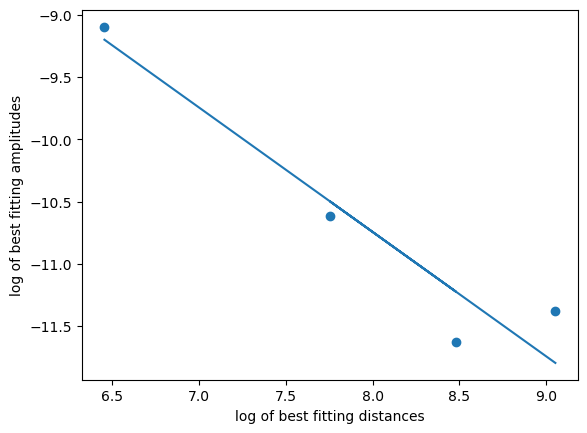

R2: 0.9079375167688613 at  ts 8050
[-11.39816042 -10.61498292 -11.62152942  -9.09630267]
[-11.74292241 -10.49123391 -11.1933887   -9.3034304 ]
[-0.34476199  0.12374901  0.42814072 -0.20712773]
0.3603810192807396


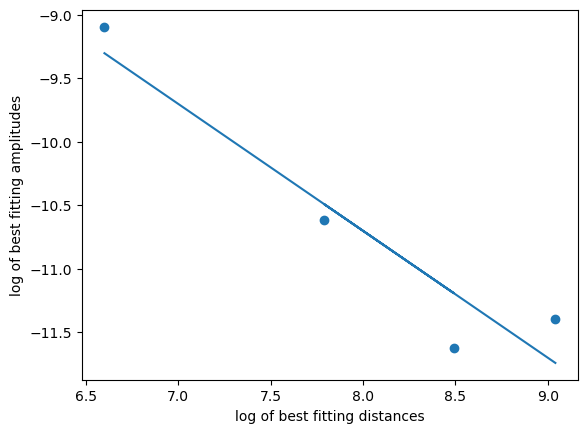

R2: 0.9010434382876698 at  ts 8050
[-11.40881074 -10.61536138 -11.61807908  -9.09609983]
[-11.69352719 -10.48561152 -11.16750139  -9.39171095]
[-0.28471645  0.12974986  0.4505777  -0.29561111]
0.38830467355029896


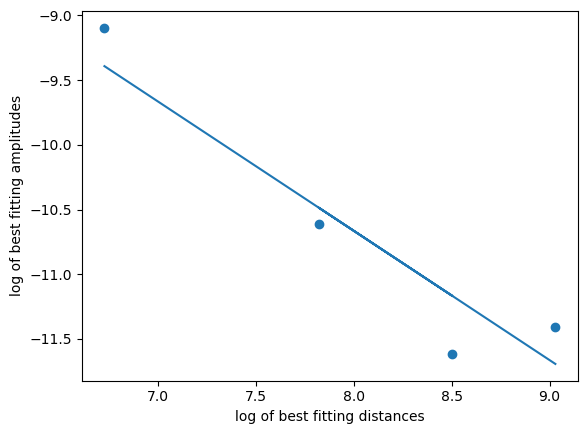

R2: 0.9075749503563614 at  ts 8060
[-11.43094715 -10.44326544 -11.64127031  -9.20018015]
[-11.85635193 -10.51626651 -11.26053732  -9.08250729]
[-0.42540478 -0.07300108  0.380733    0.11767286]
0.34510289651258463


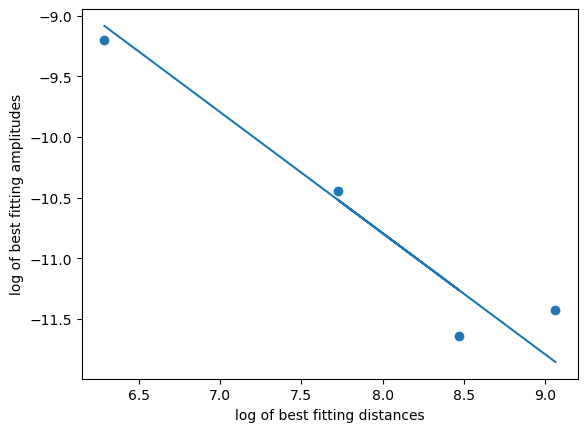

R2: 0.9154986987245077 at  ts 8060
[-11.42633261 -10.44163521 -11.64241957  -9.19768518]
[-11.79289353 -10.49712711 -11.22009191  -9.19796003]
[-3.66560915e-01 -5.54919016e-02  4.22327661e-01 -2.74844119e-04]
0.31580698483397707


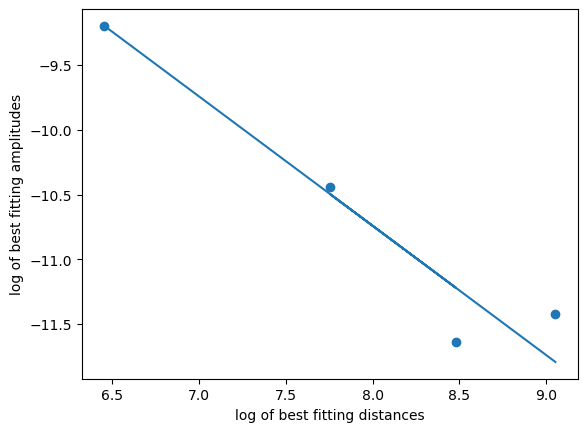

R2: 0.9100906004599459 at  ts 8060
[-11.4056389  -10.43148581 -11.64787714  -9.19964448]
[-11.73134014 -10.47965164 -11.18180643  -9.29184813]
[-0.32570124 -0.04816583  0.46607071 -0.09220365]
0.33412466105921923


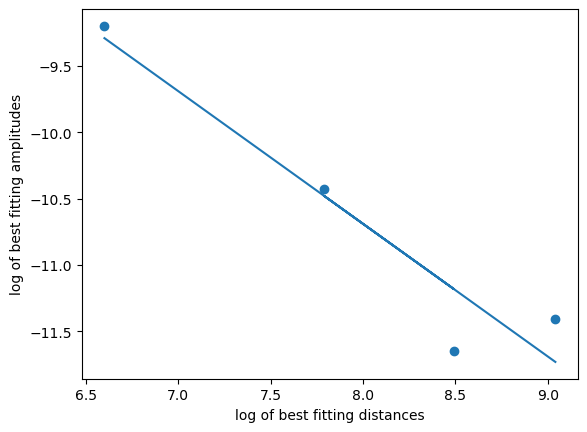

R2: 0.9028331836010711 at  ts 8060
[-11.39547941 -10.43081359 -11.64938745  -9.19927207]
[-11.67767756 -10.46976189 -11.15165176  -9.37586132]
[-0.28219815 -0.0389483   0.49773569 -0.17658925]
0.3600773443086771


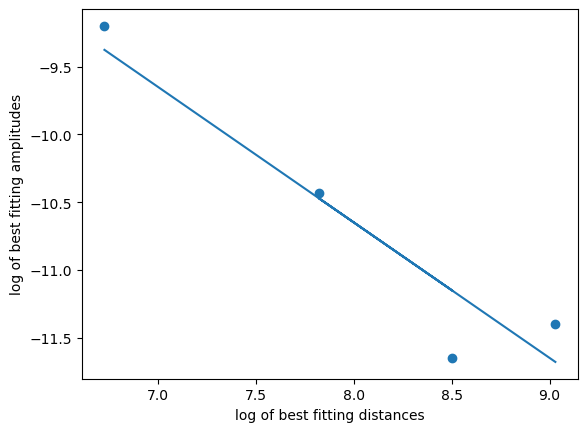

R2: 0.9046655533846719 at  ts 8070
[-11.62657302 -10.52382675 -11.7057605   -9.27083485]
[-11.68836078 -10.58413796 -11.22132748  -9.63316889]
[-0.06178776 -0.06031121  0.48443302 -0.36233404]
0.373416479868063


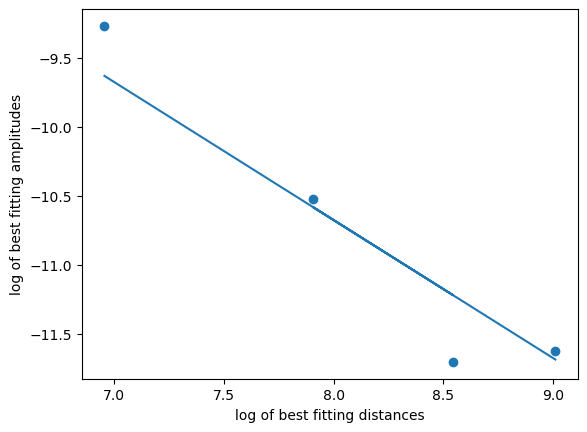

R2: 0.9381769276410721 at  ts 8070
[-11.61542546 -10.53441788 -11.68952719  -9.27046921]
[-11.9548961  -10.61481069 -11.35908149  -9.18105147]
[-0.33947064 -0.08039281  0.3304457   0.08941774]
0.23889321648945178


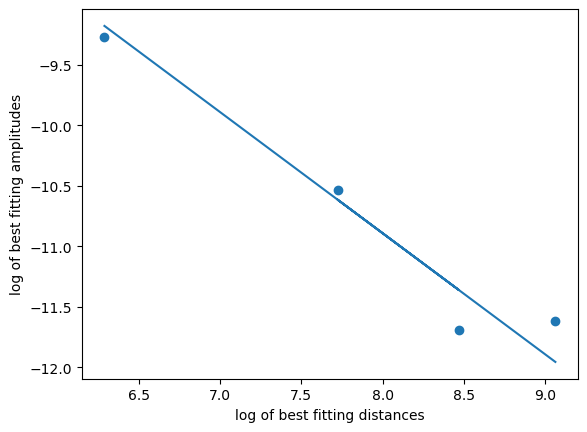

R2: 0.9441926430549388 at  ts 8070
[-11.61907326 -10.53452468 -11.68860332  -9.27437898]
[-11.89502044 -10.59925403 -11.32221882  -9.30008694]
[-0.27594719 -0.06472934  0.3663845  -0.02570797]
0.21523523546246173


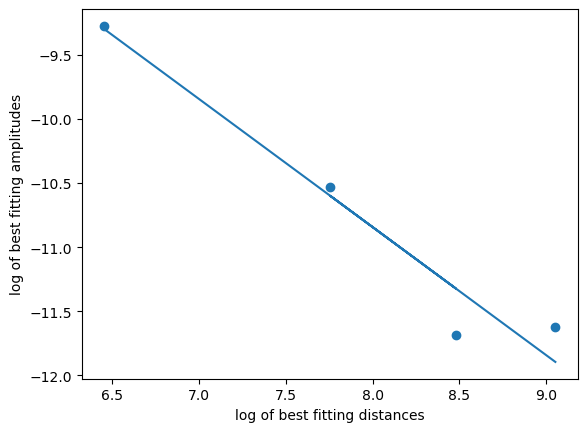

R2: 0.941917831705641 at  ts 8070
[-11.62314964 -10.53817079 -11.68911457  -9.27440381]
[-11.84138826 -10.58969976 -11.29185455  -9.40189625]
[-0.21823862 -0.05152897  0.39726002 -0.12749244]
0.2243531786941024


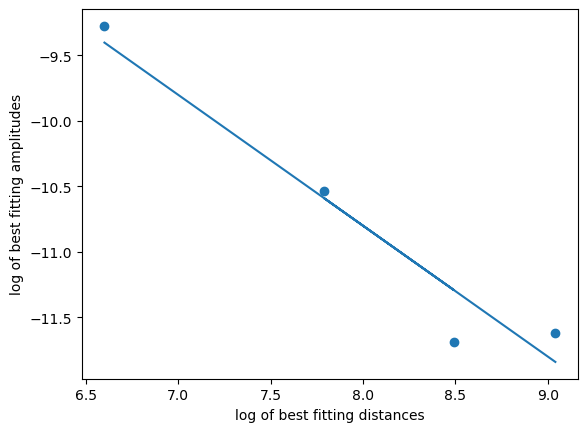

R2: 0.9327482164695782 at  ts 8070
[-11.62130744 -10.53464495 -11.69234048  -9.27365542]
[-11.7894265  -10.58151083 -11.2634007   -9.48761026]
[-0.16811906 -0.04686588  0.42893978 -0.21395484]
0.2602264387678694


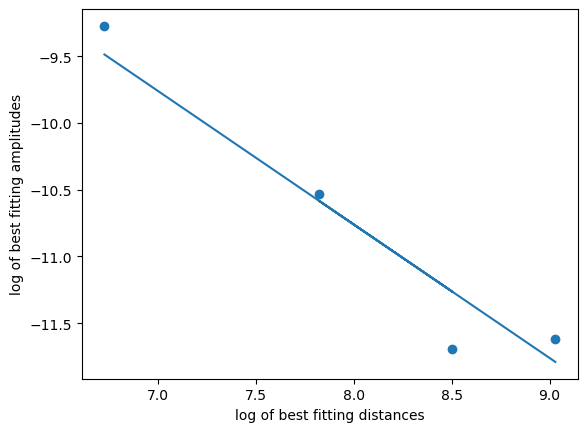

R2: 0.920083349699264 at  ts 8070
[-11.62482002 -10.52468758 -11.69812396  -9.27367034]
[-11.74152668 -10.57703042 -11.23923478  -9.56351001]
[-0.11670666 -0.05234285  0.45888918 -0.28983968]
0.3109465388171929


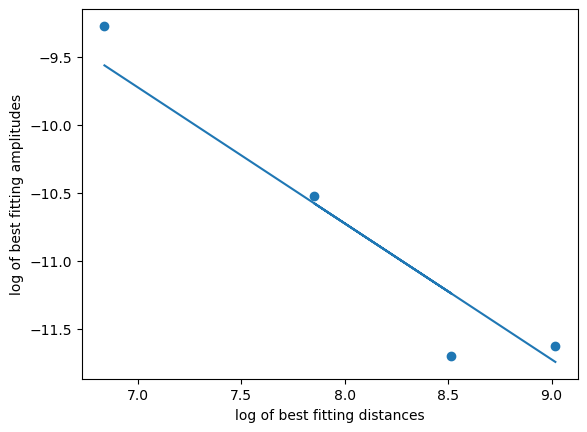

R2: 0.9168824200656551 at  ts 8070
[-11.61561005 -10.5300587  -11.68513913  -9.26481506]
[-12.03767484 -10.62555163 -11.40465449  -9.02774198]
[-0.42206478 -0.09549294  0.28048464  0.23707308]
0.322132860807817


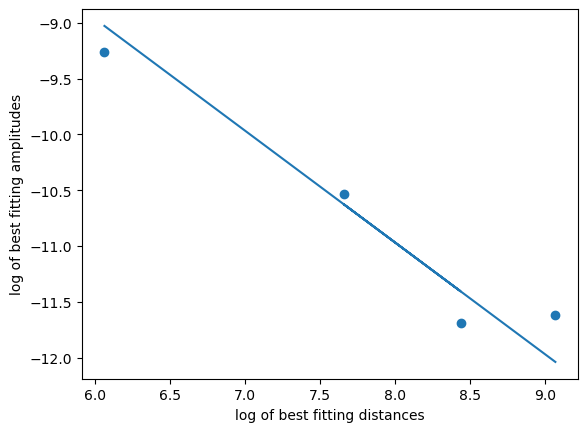

R2: 0.9282909169737807 at  ts 8090
[-11.53689457 -10.32828645 -11.63883178  -9.17768876]
[-11.84786155 -10.50777614 -11.25204694  -9.07401692]
[-0.31096699 -0.17948968  0.38678484  0.10367184]
0.2892673757495128


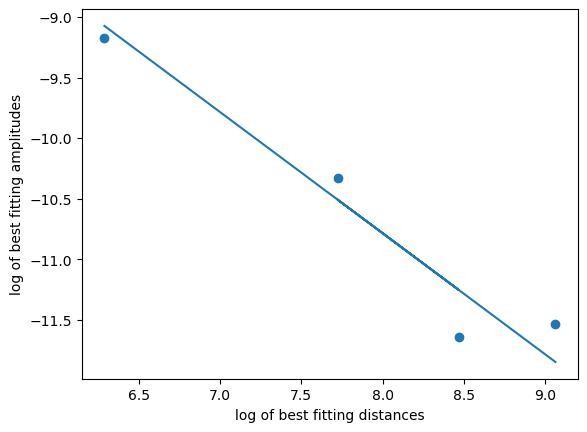

R2: 0.9336040952031651 at  ts 8090
[-11.53486503 -10.32822436 -11.63387685  -9.18059002]
[-11.78526445 -10.48949804 -11.21246283  -9.19033095]
[-0.25039942 -0.16127367  0.42141402 -0.00974093]
0.26639373383695336


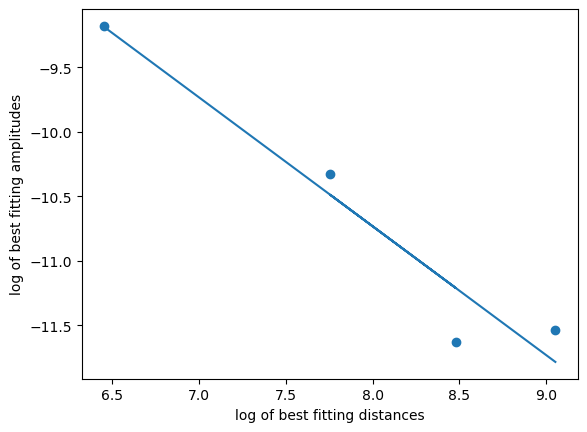

R2: 0.9297625387291224 at  ts 8090
[-11.53052494 -10.32087279 -11.63315772  -9.18580274]
[-11.7277681  -10.4760796  -11.17823439  -9.28827609]
[-0.19724316 -0.15520681  0.45492332 -0.10247335]
0.2804500381954513


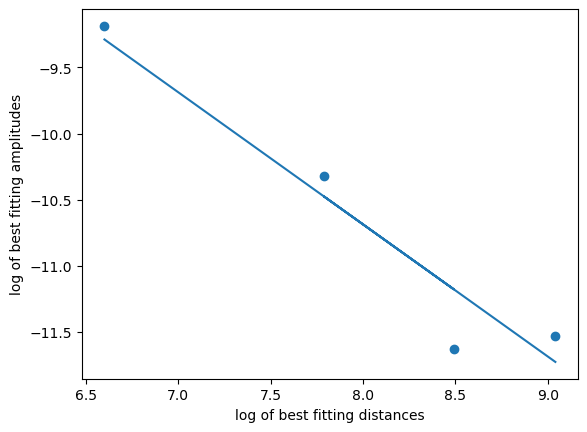

R2: 0.9207571433062549 at  ts 8090
[-11.5183832  -10.32113882 -11.63105573  -9.17811062]
[-11.67111152 -10.46319585 -11.14508572  -9.36929528]
[-0.15272832 -0.14205703  0.48597002 -0.19118466]
0.31622457247142094


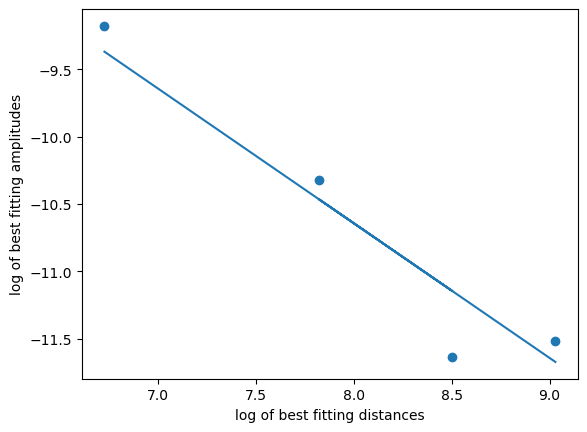

R2: 0.9070550815544131 at  ts 8090
[-11.49866381 -10.31166272 -11.62947173  -9.17313394]
[-11.61443426 -10.449938   -11.11214235  -9.43641759]
[-0.11577045 -0.13827528  0.51732937 -0.26328365]
0.36947080924490694


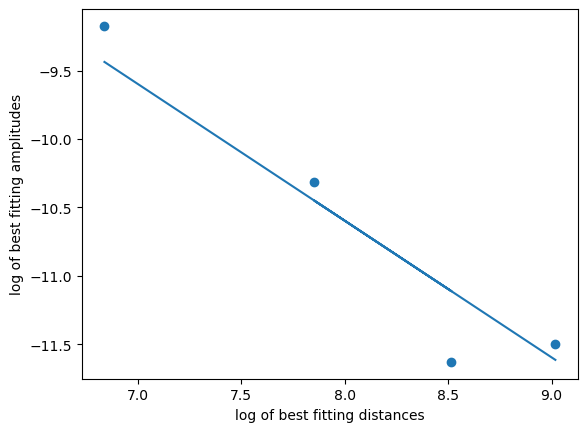

R2: 0.9078850543370337 at  ts 8090
[-11.53924951 -10.34292618 -11.63773872  -9.18454479]
[-11.9398839  -10.5277607  -11.30686356  -8.92995105]
[-0.40063439 -0.18483452  0.33087516  0.25459375]
0.3689680581716095


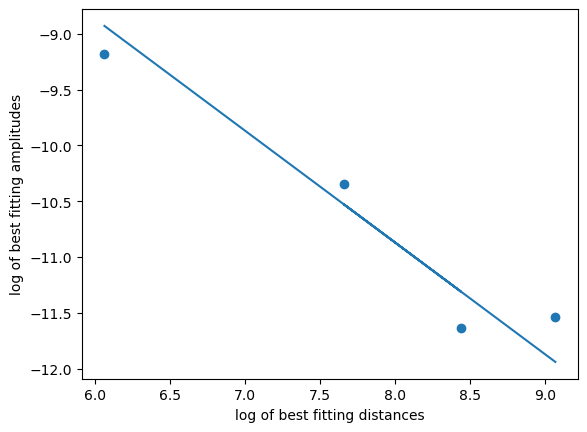

R2: 0.9010024180435181 at  ts 8280
[-11.33924721  -9.58009242 -11.22783843  -8.83476111]
[-11.42292096 -10.08283554 -10.82710635  -8.64907633]
[-0.08367375 -0.50274312  0.40073209  0.18568479]
0.45481698828436223


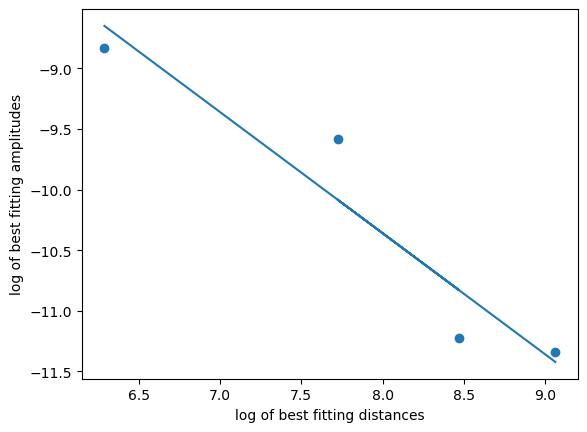

R2: 0.9064542942475983 at  ts 8280
[-11.33854817  -9.58000581 -11.22680001  -8.82566919]
[-11.35863118 -10.06286476 -10.78582956  -8.76369768]
[-0.02008301 -0.48285895  0.44097045  0.06197151]
0.43185149946907725


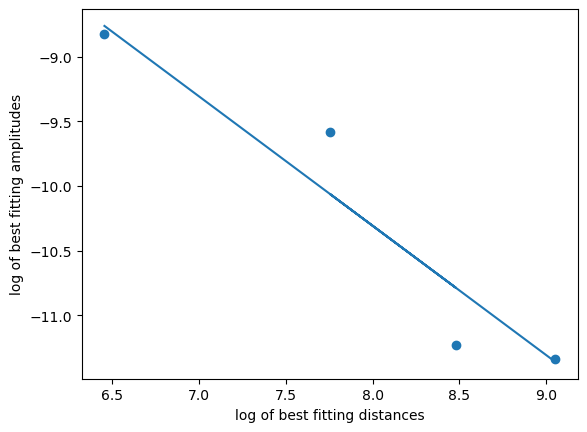

R2: 0.9035647799151733 at  ts 8280
[-11.33944711  -9.58296699 -11.2259002   -8.82327518]
[-11.30307592 -10.05138742 -10.75354221  -8.86358391]
[ 0.03637118 -0.46842044  0.47235799 -0.04030874]
0.4454874347340681


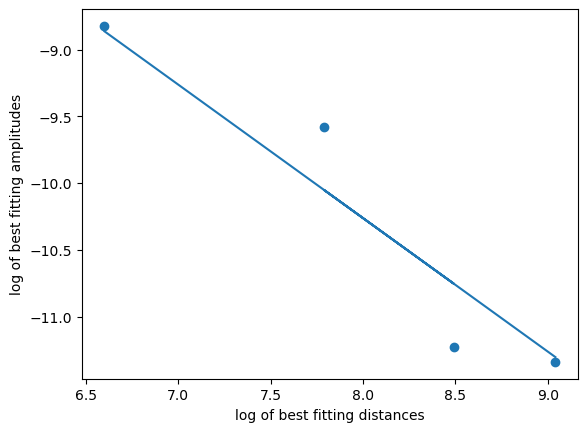

R2: 0.9326734639581437 at  ts 8280
[-11.38192397  -9.58300867 -11.20188594  -8.83455111]
[-11.69297542  -9.81755268 -10.85324204  -8.63759955]
[-0.31105145 -0.23454401  0.3486439   0.19695156]
0.3121063798236721


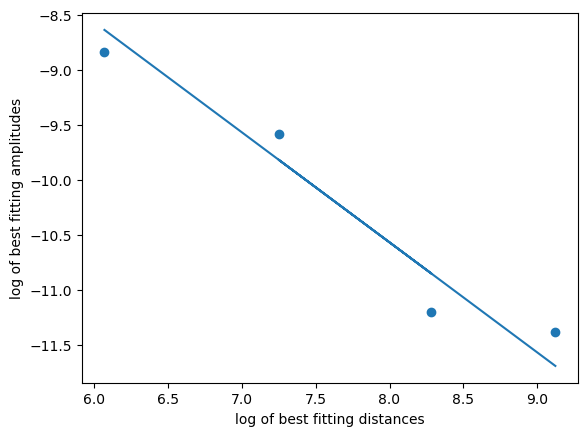

R2: 0.9228494786235744 at  ts 8280
[-11.38036569  -9.58567592 -11.20382495  -8.836211  ]
[-11.68772424  -9.87365251 -10.87143026  -8.57327055]
[-0.30735855 -0.28797659  0.33239469  0.26294045]
0.35702369900298164


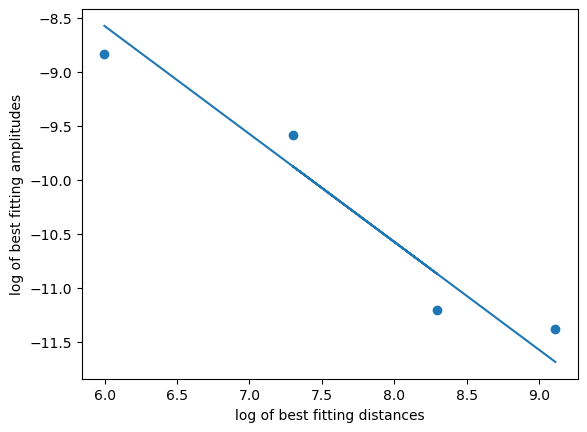

R2: 0.9428180576209568 at  ts 8280
[-11.38316217  -9.58837237 -11.20253683  -8.83203705]
[-11.66801939  -9.6784359  -10.78510722  -8.87454589]
[-0.28485722 -0.09006354  0.4174296  -0.04250884]
0.26530955377207216


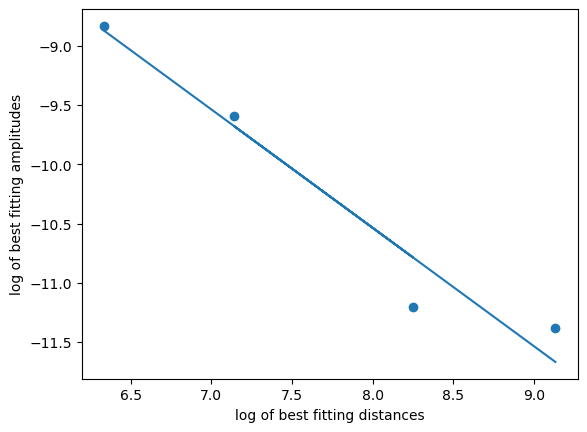

R2: 0.9221566002203078 at  ts 8280
[-11.38432426  -9.58995106 -11.20386138  -8.82383324]
[-11.657711    -9.54127322 -10.73034717  -9.07263854]
[-0.27338675  0.04867784  0.47351421 -0.2488053 ]
0.3632296274834563


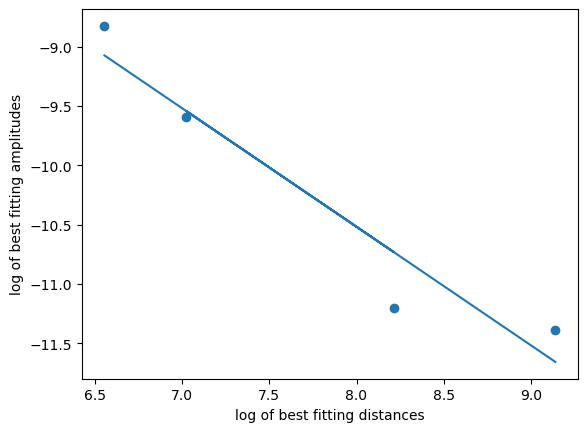

R2: 0.9121827592545697 at  ts 8340
[-11.3671364   -9.47867626 -11.4051925   -8.5861445 ]
[-11.65192041  -9.77649767 -10.81218704  -8.59654454]
[-0.28478401 -0.29782141  0.59300547 -0.01040004]
0.521563174912912


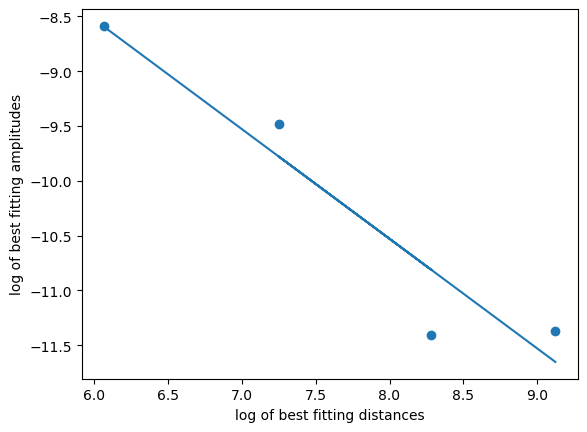

R2: 0.9102823895358355 at  ts 8340
[-11.36910035  -9.48233153 -11.40519076  -8.58546032]
[-11.64672559  -9.83265386 -10.83043161  -8.5322719 ]
[-0.27762524 -0.35032233  0.57475915  0.05318842]
0.5329785961784901


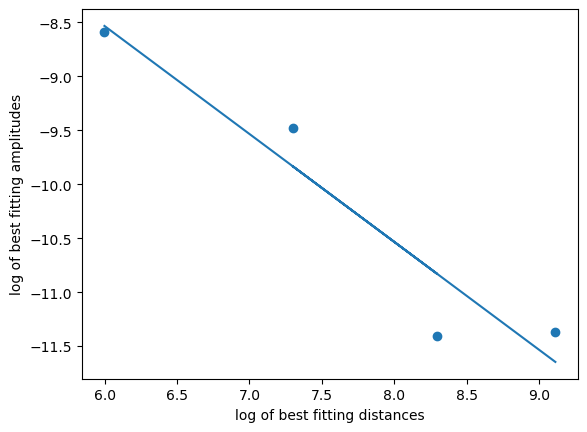

R2: 0.9007485985276736 at  ts 8340
[-11.36678807  -9.47611184 -11.40372587  -8.58983454]
[-11.62560737  -9.63602388 -10.7426952   -8.83213386]
[-0.2588193  -0.15991204  0.66103067 -0.24229933]
0.5882297980368558


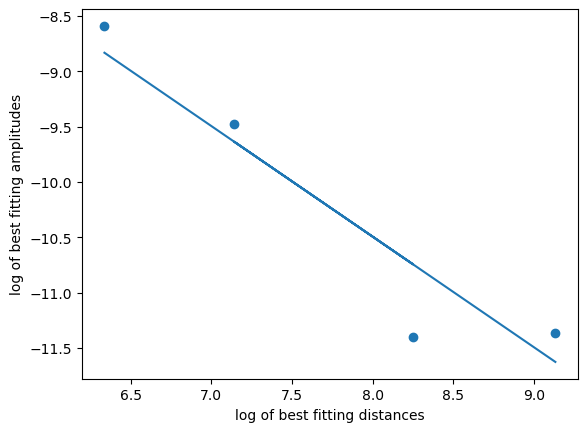

R2: 0.9009813226782072 at  ts 8520
[-11.39420224  -8.94373028 -11.18682478  -9.27962857]
[-11.63460001  -9.13105556 -10.58992737  -9.44880292]
[-0.24039777 -0.18732529  0.59689742 -0.16917436]
0.4777883409003544


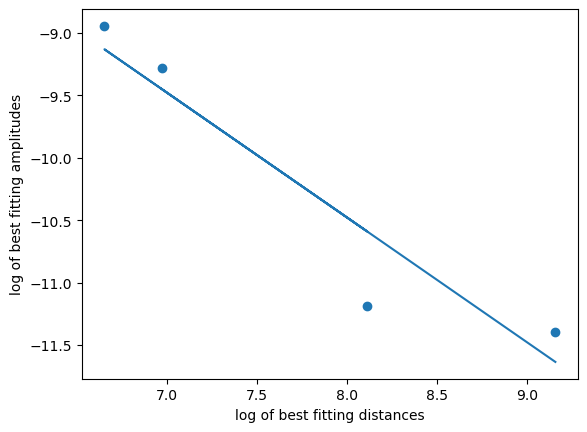

R2: 0.9085225355374453 at  ts 8530
[-11.28961546  -8.86829408 -11.05989065  -9.31993332]
[-11.56793693  -9.06439248 -10.52326428  -9.38213983]
[-0.27832146 -0.1960984   0.53662637 -0.06220651]
0.4077549324873417


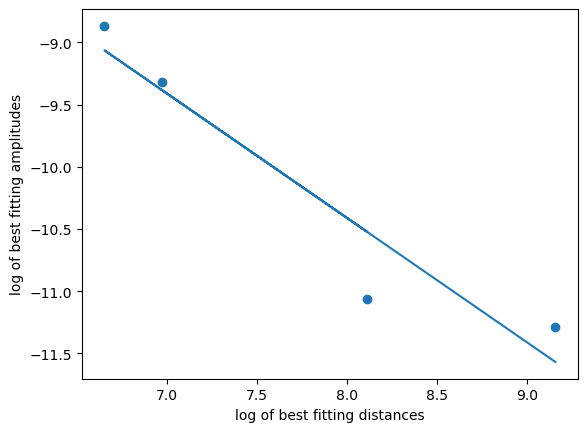

R2: 0.9043190946497214 at  ts 8620
[-11.46698117  -8.9549021  -11.20979643  -9.13233396]
[-11.60098227  -9.27306608 -10.60482585  -9.28513944]
[-0.13400111 -0.31816399  0.60497057 -0.15280548]
0.5085235283485077


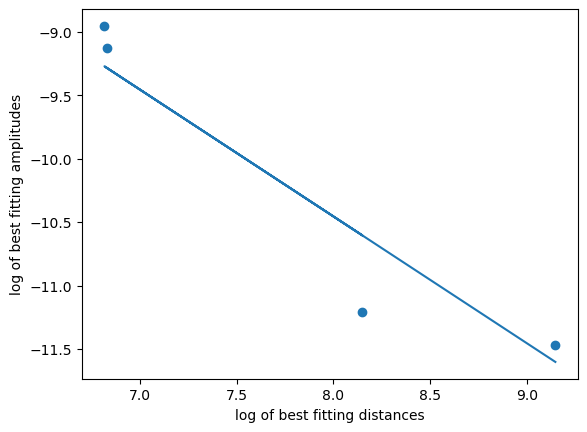

R2: 0.905977699597938 at  ts 8620
[-11.46791769  -8.96223739 -11.16857737  -9.13097363]
[-11.61593007  -9.11238562 -10.57125742  -9.43013298]
[-0.14801238 -0.15014822  0.59731995 -0.29915935]
0.4907395940948991


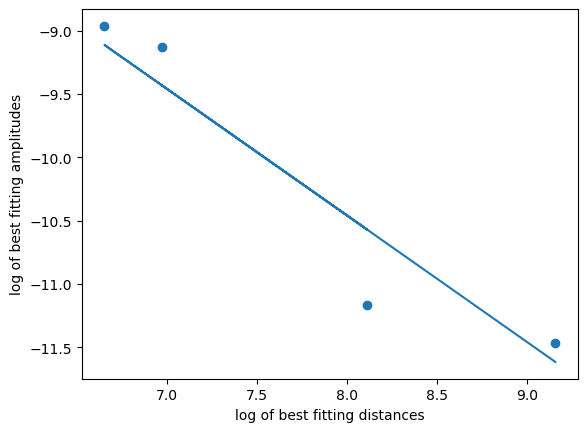

R2: 0.9034288215791874 at  ts 8670
[-11.39061571  -9.1545841  -11.24799826  -9.02123859]
[-11.61082768  -9.4943899  -10.68346385  -9.02575522]
[-0.22021197 -0.33980581  0.56453441 -0.00451663]
0.4826807981752996


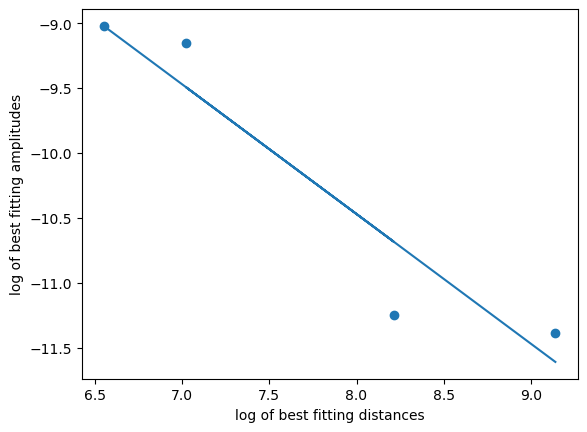

R2: 0.9041345198213803 at  ts 8670
[-11.39022862  -9.15390298 -11.24108494  -9.02149254]
[-11.59964635  -9.42349695 -10.65050858  -9.13305721]
[-0.20941772 -0.26959397  0.59057635 -0.11156466]
0.47776379457819873


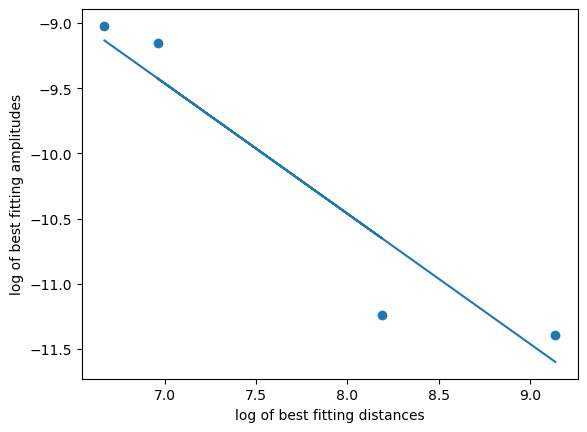

R2: 0.9053879819619706 at  ts 8680
[-11.42106758  -9.25815346 -11.20124374  -9.05715707]
[-11.65089775  -9.66131426 -10.76798558  -8.85742425]
[-0.22983017 -0.40316081  0.43325816  0.19973282]
0.4429663728523402


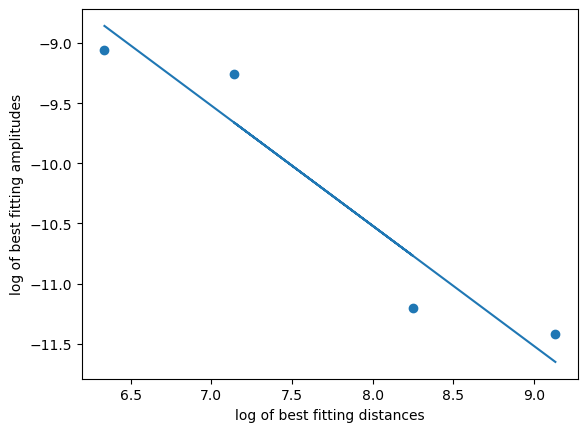

R2: 0.920404354092342 at  ts 8680
[-11.41402319  -9.2526326  -11.21038879  -9.06423023]
[-11.64253722  -9.52609944 -10.71517339  -9.05746476]
[-0.22851403 -0.27346684  0.4952154   0.00676547]
0.3722868347710918


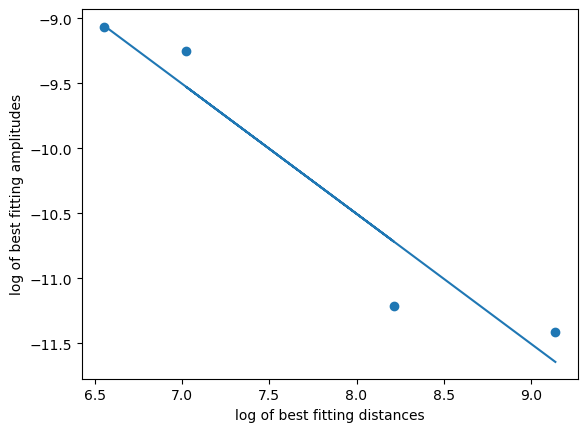

R2: 0.9189120319935197 at  ts 8680
[-11.41597245  -9.25160768 -11.21363887  -9.06453676]
[-11.63440802  -9.45825862 -10.68527025  -9.16781888]
[-0.21843557 -0.20665094  0.52836862 -0.10328211]
0.38025929526881636


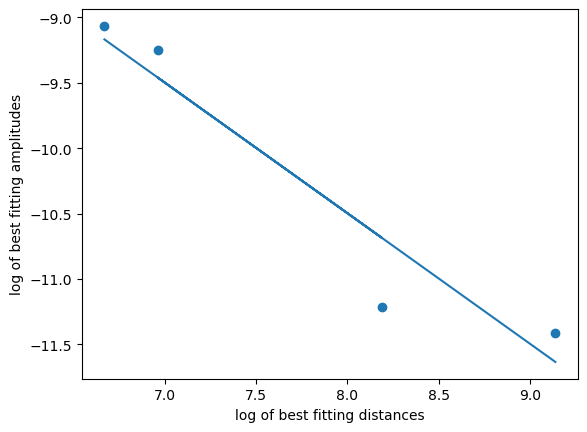

R2: 0.9044455123922733 at  ts 8680
[-11.41193479  -9.24389474 -11.21298872  -9.06264458]
[-11.64284457  -9.31492838 -10.64668815  -9.32700174]
[-0.23090978 -0.07103364  0.56630057 -0.26435715]
0.44894614021629153


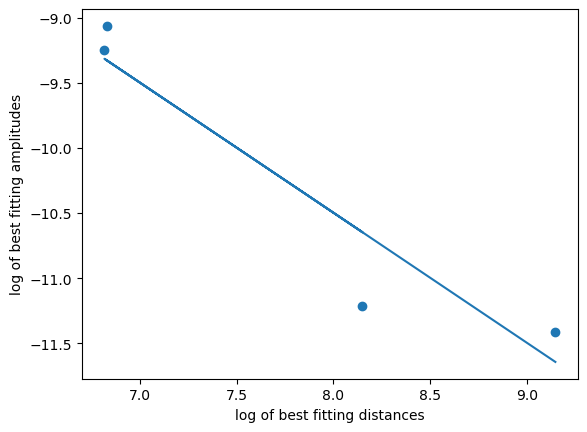

R2: 0.9257094478756388 at  ts 8690
[-11.57885663  -9.38281662 -11.19315945  -8.90394601]
[-11.70732767  -9.83190494 -10.8675943   -8.65195181]
[-0.12847105 -0.44908832  0.32556516  0.25199421]
0.387678879468684


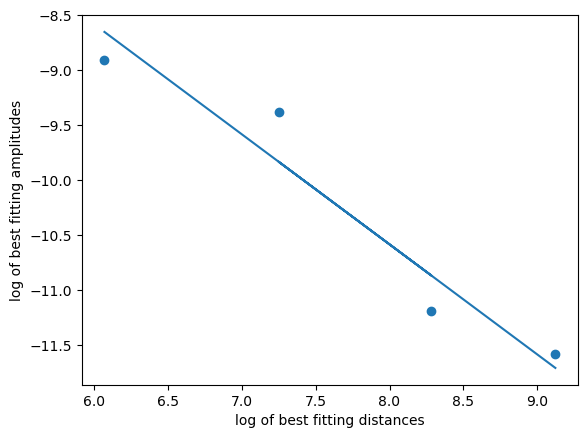

R2: 0.9104998243967719 at  ts 8690
[-11.5743701   -9.38112917 -11.19347671  -8.90209827]
[-11.69897341  -9.88490168 -10.88267943  -8.58451972]
[-0.12460331 -0.50377252  0.31079728  0.31757855]
0.46676381481121876


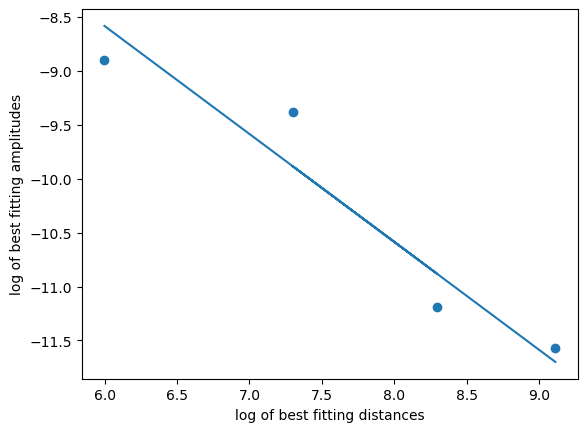

R2: 0.9521581205689008 at  ts 8690
[-11.59778031  -9.3838643  -11.18477572  -8.90363412]
[-11.6840059   -9.69442241 -10.80109373  -8.8905324 ]
[-0.0862256  -0.31055812  0.38368199  0.01310173]
0.25126471941119266


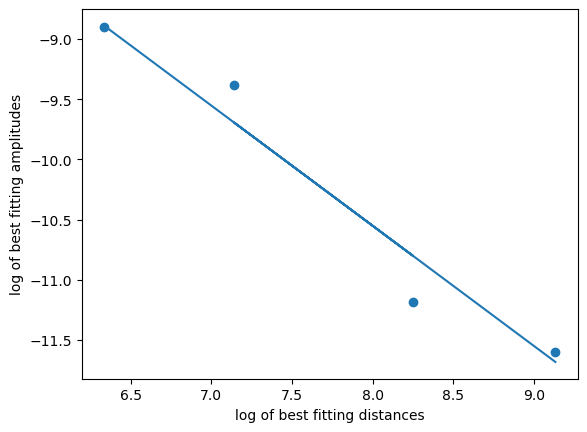

R2: 0.9517115578160746 at  ts 8690
[-11.61388051  -9.38222024 -11.17608806  -8.89574432]
[-11.6742018   -9.55776402 -10.74683797  -9.08912934]
[-0.06032129 -0.17554378  0.42925009 -0.19338502]
0.2561076805253524


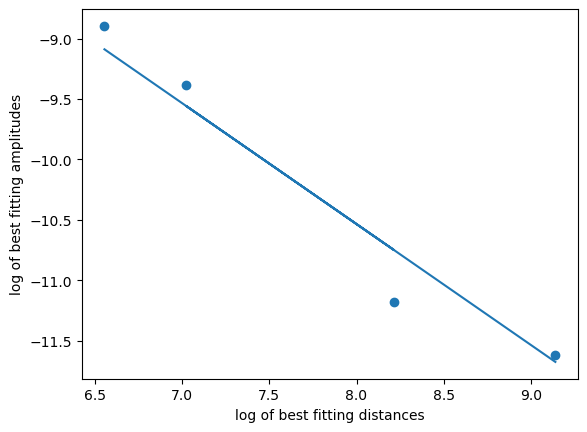

R2: 0.9387596647595784 at  ts 8690
[-11.60996426  -9.38680697 -11.1822835   -8.89176343]
[-11.66567362  -9.48952422 -10.71653585  -9.19908448]
[-0.05570935 -0.10271725  0.46574765 -0.30732104]
0.32502146247583863


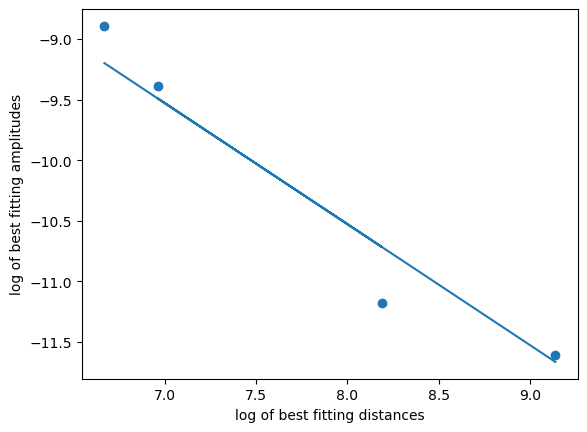

R2: 0.9100681087192436 at  ts 8690
[-11.61660128  -9.39203804 -11.18742598  -8.89668936]
[-11.68316753  -9.35525134 -10.68701111  -9.36732469]
[-0.06656625  0.03678671  0.50041487 -0.47063533]
0.47769698990279386


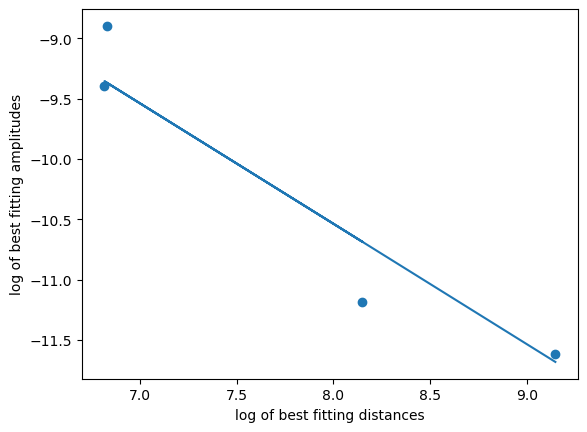

R2: 0.9176786474312004 at  ts 8700
[-11.58871927  -9.42538208 -11.31988208  -8.91369308]
[-11.75455212  -9.87912939 -10.91481875  -8.69917626]
[-0.16583286 -0.4537473   0.40506333  0.21451683]
0.44348092531244154


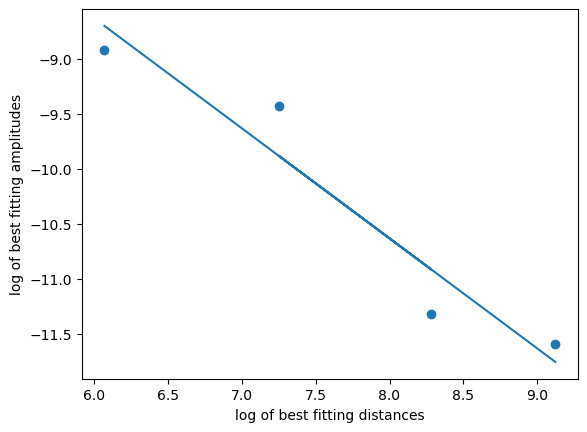

R2: 0.9051367548689365 at  ts 8700
[-11.58889895  -9.42739181 -11.31996212  -8.91327093]
[-11.7485858   -9.93451407 -10.93229183  -8.63413211]
[-0.15968685 -0.50712226  0.38767029  0.27913882]
0.5108796159753889


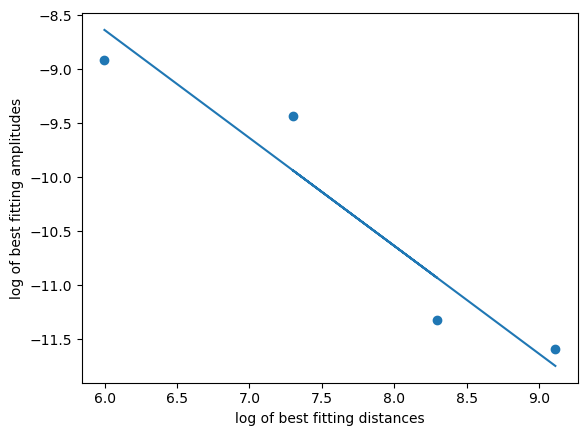

R2: 0.9355594083765972 at  ts 8700
[-11.58852374  -9.42456901 -11.32490357  -8.90812387]
[-11.72802234  -9.73843885 -10.84511017  -8.93454883]
[-0.1394986  -0.31386983  0.4797934  -0.02642496]
0.3488741159425323


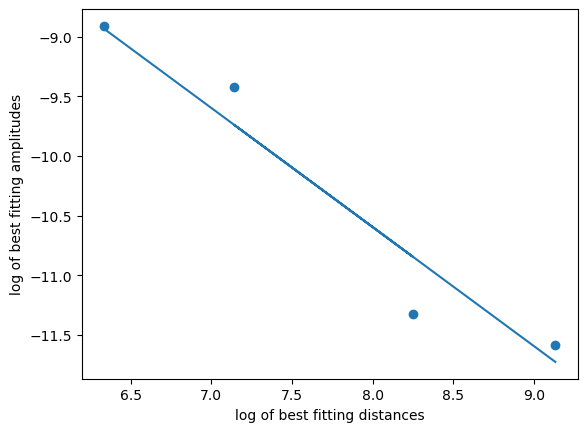

R2: 0.929306479839684 at  ts 8700
[-11.58440798  -9.42666902 -11.32422415  -8.91652408]
[-11.72017482  -9.60373704 -10.792811    -9.13510236]
[-0.13576685 -0.17706803  0.53141315 -0.21857828]
0.3799621257801524


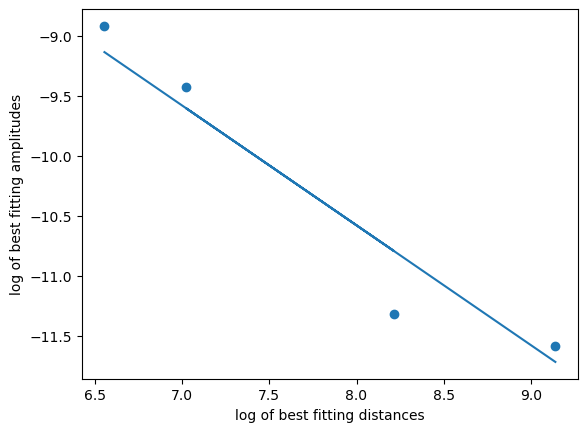

R2: 0.9184257719281071 at  ts 8700
[-11.58591646  -9.42327634 -11.311804    -8.9183807 ]
[-11.70781345  -9.53166405 -10.75867569  -9.24122431]
[-0.12189699 -0.10838771  0.55312832 -0.32284361]
0.43678570387505583


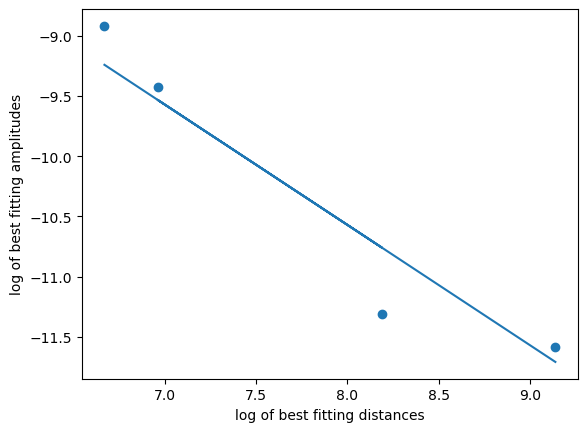

R2: 0.9152288453725876 at  ts 8710
[-11.5914404   -9.42613715 -11.38898886  -8.85984769]
[-11.75923652  -9.88381378 -10.91950314  -8.70386065]
[-0.16779612 -0.45767663  0.46948571  0.15598703]
0.4823722235429381


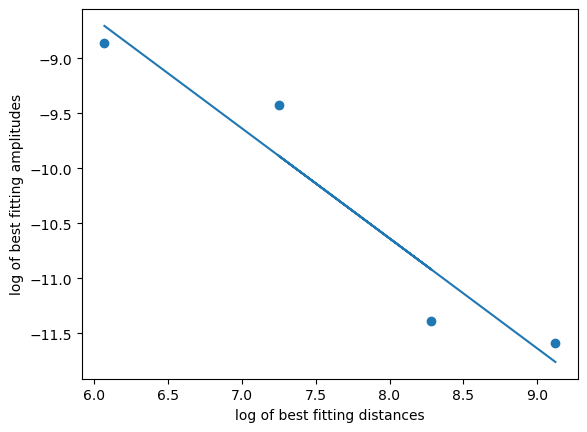

R2: 0.9064926315355254 at  ts 8710
[-11.59209661  -9.42247773 -11.36977109  -8.85987686]
[-11.74726042  -9.93318869 -10.93096645  -8.63280673]
[-0.1551638  -0.51071097  0.43880464  0.22707013]
0.5290118531598013


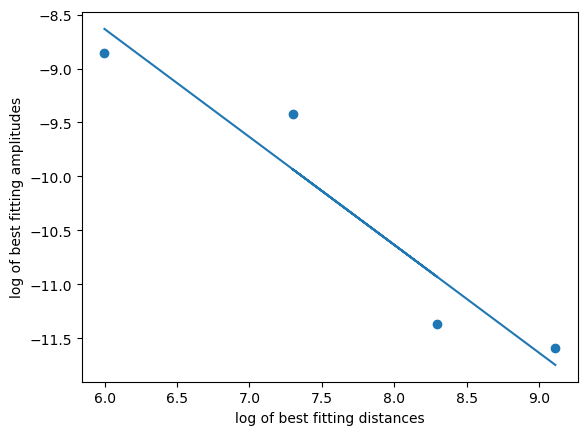

R2: 0.924277167368925 at  ts 8710
[-11.58703323  -9.43113504 -11.40348821  -8.86605832]
[-11.73842099  -9.7488375  -10.85550882  -8.94494749]
[-0.15138777 -0.31770246  0.54797939 -0.07888917]
0.4303580236206536


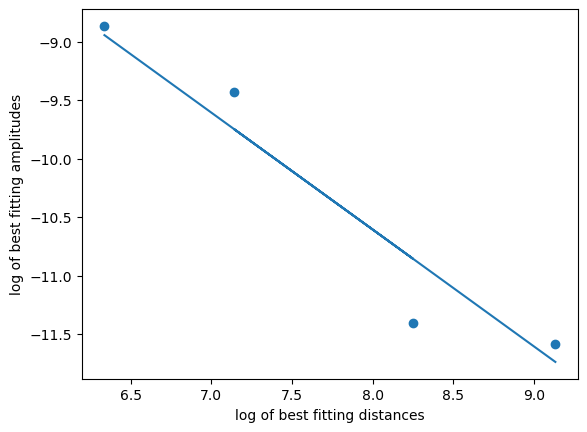

R2: 0.9094110854087905 at  ts 8710
[-11.57704233  -9.43266742 -11.41876062  -8.85992179]
[-11.72931656  -9.61287878 -10.80195273  -9.1442441 ]
[-0.15227422 -0.18021136  0.61680789 -0.28432231]
0.5169547198199539


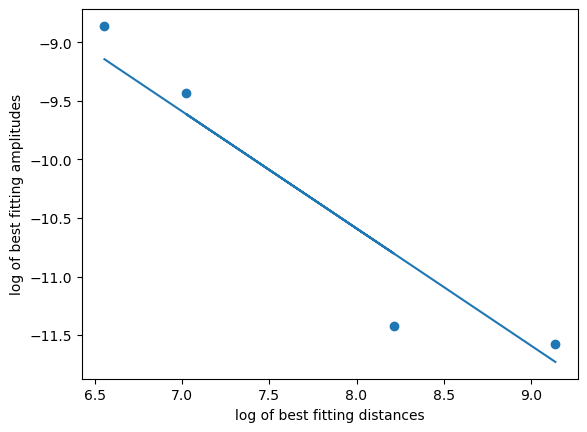

R2: 0.9020542528258372 at  ts 8720
[-11.42575066  -9.44356102 -11.40128871  -8.96722806]
[-11.72594941  -9.73636591 -10.84303724  -8.9324759 ]
[-0.30019875 -0.29280489  0.55825148  0.03475216]
0.4887064164742098


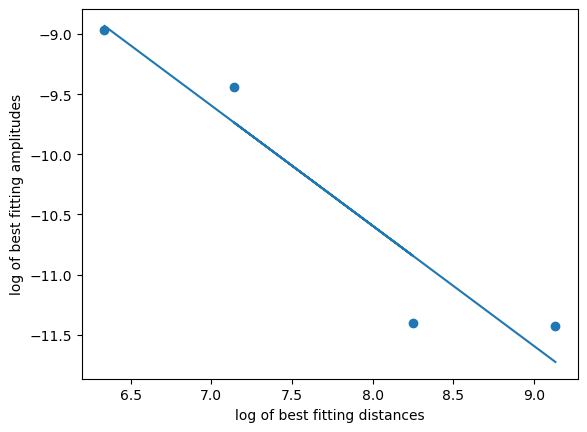

R2: 0.9039036647964491 at  ts 8730
[-11.5262542   -9.40197323 -11.43798323  -9.02631906]
[-11.75535095  -9.63891317 -10.82798712  -9.17027849]
[-0.22909675 -0.23693993  0.60999611 -0.14395943]
0.5014454257098058


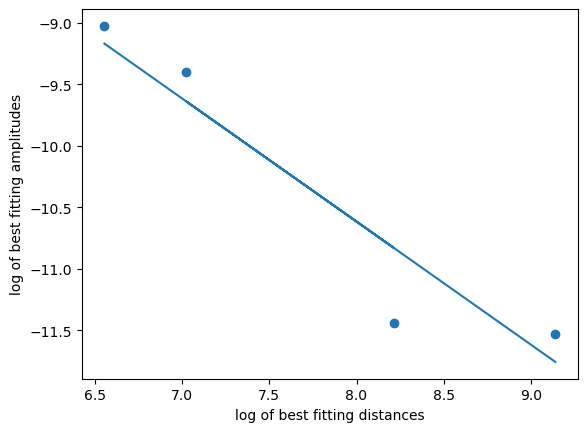

R2: 0.9065565409635188 at  ts 8760
[-11.73479163  -9.58557941 -11.46507303  -8.77892611]
[-11.86553362 -10.15073413 -11.09100813  -8.45709432]
[-0.13074199 -0.56515472  0.37406491  0.3218318 ]
0.57999358214077


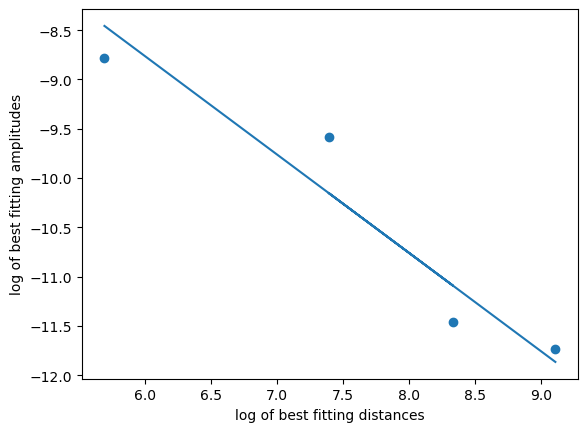

R2: 0.9388606342784773 at  ts 8760
[-11.71667974  -9.58879529 -11.47125785  -8.77403779]
[-11.83032567  -9.95490293 -10.99059229  -8.7749498 ]
[-0.11364592 -0.36610763  0.48066556 -0.00091201]
0.3779904129535034


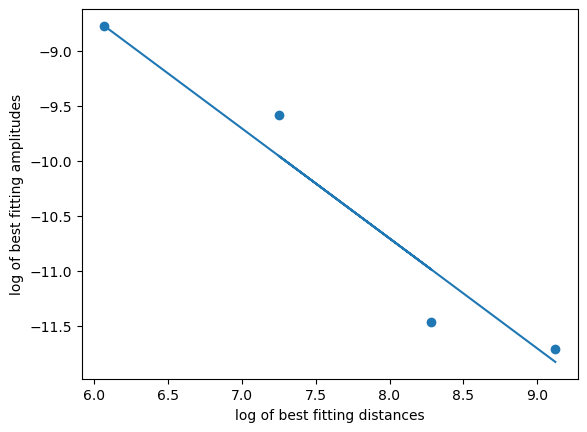

R2: 0.9341089045494193 at  ts 8760
[-11.72537248  -9.58773975 -11.47256305  -8.77694601]
[-11.82686017 -10.01278845 -11.0105662   -8.71240648]
[-0.10148769 -0.42504869  0.46199685  0.06453953]
0.4085725877657416


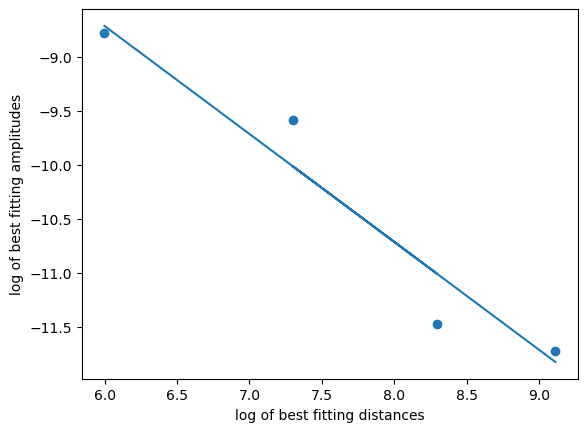

R2: 0.9320133000522772 at  ts 8760
[-11.7142531   -9.58842344 -11.47343174  -8.77361065]
[-11.80392202  -9.81433853 -10.92100985  -9.01044852]
[-0.08966892 -0.22591509  0.55242189 -0.23683787]
0.4203402615163865


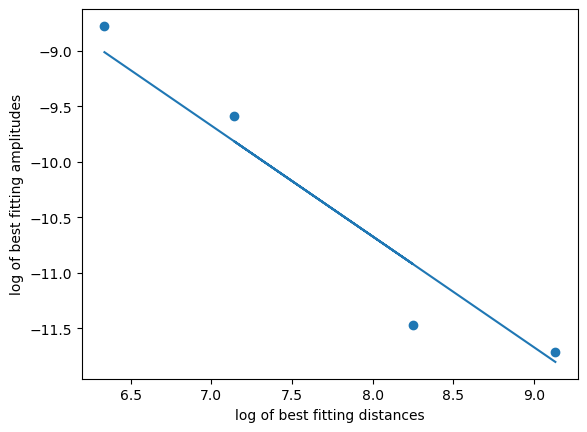

R2: 0.9059424198281444 at  ts 8760
[-11.7224191   -9.58962074 -11.48818927  -8.77724028]
[-11.80158587  -9.68514808 -10.87422204  -9.2165134 ]
[-0.07916677 -0.09552734  0.61396724 -0.43927313]
0.5853094976156751


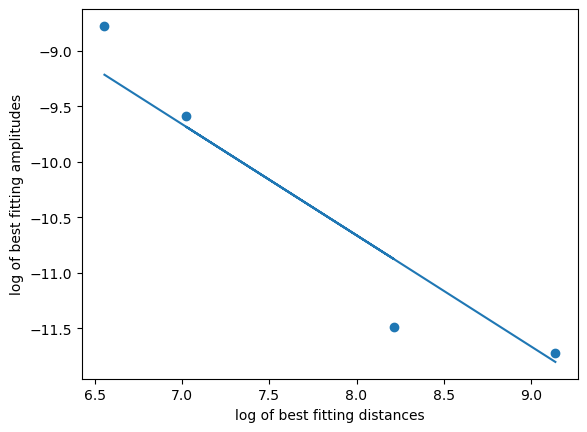

R2: 0.9106645500310013 at  ts 8770
[-11.38524201  -9.65994707 -11.44420814  -8.76548024]
[-11.75635236  -9.88092962 -10.91661898  -8.70097649]
[-0.37111035 -0.22098256  0.52758916  0.06450375]
0.4690672387970869


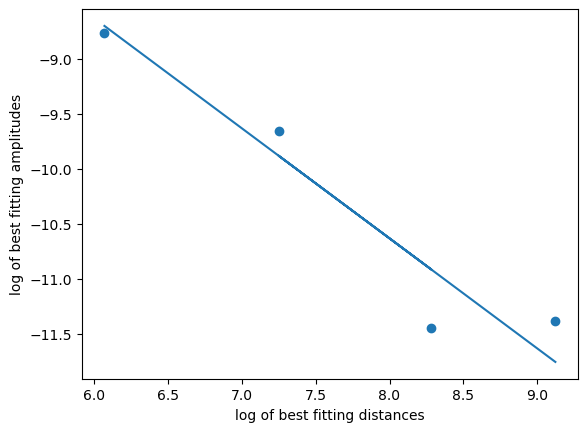

R2: 0.9087636516557601 at  ts 8770
[-11.39236574  -9.66097747 -11.44499539  -8.76306276]
[-11.75155519  -9.93748346 -10.93526121  -8.6371015 ]
[-0.35918945 -0.27650599  0.50973418  0.12596126]
0.4811677908382864


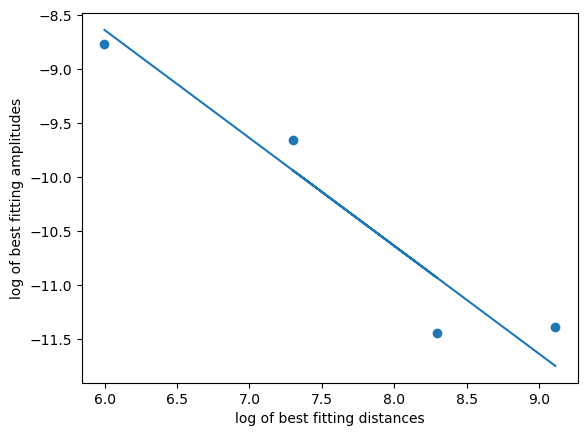

R2: 0.9039801673396266 at  ts 8770
[-11.38460886  -9.65615554 -11.43621735  -8.76335114]
[-11.72657551  -9.73699202 -10.84366334  -8.93310201]
[-0.34196665 -0.08083648  0.592554   -0.16975087]
0.5034113338427556


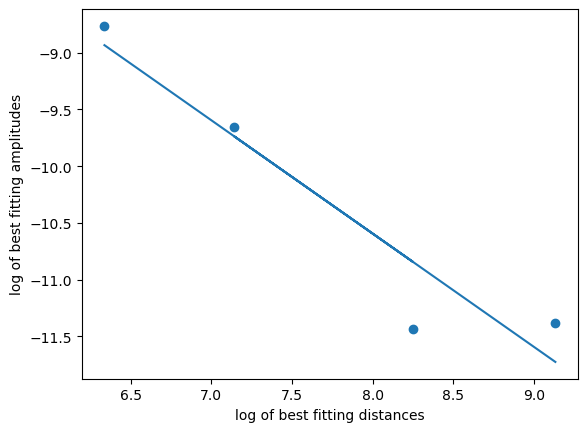

R2: 0.9140162300150702 at  ts 8780
[-11.45152316  -9.64934042 -11.44903596  -8.84350637]
[-11.79098447  -9.91556174 -10.9512511   -8.73560861]
[-0.33946131 -0.26622132  0.49778486  0.10789777]
0.44553946497172425


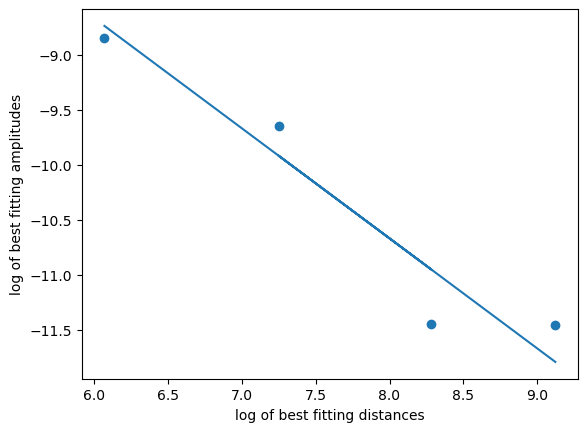

R2: 0.90615226509157 at  ts 8780
[-11.43958315  -9.64963633 -11.44643483  -8.84762772]
[-11.78202535  -9.96795363 -10.96573138  -8.66757167]
[-0.3424422  -0.3183173   0.48070345  0.18005606]
0.4820885543179909


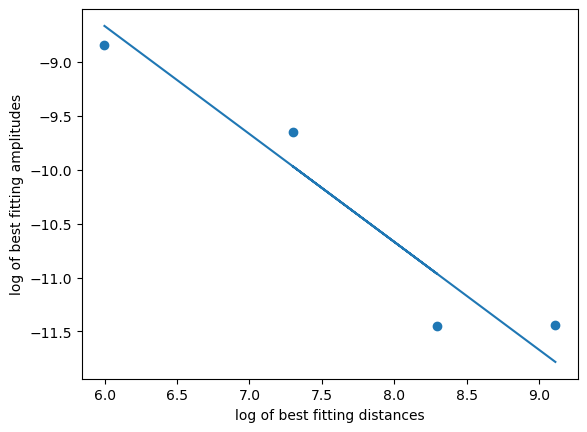

R2: 0.9123692056979172 at  ts 8780
[-11.45377556  -9.64986138 -11.45328965  -8.83935363]
[-11.76556235  -9.77597886 -10.88265018  -8.97208884]
[-0.31178679 -0.12611747  0.57063948 -0.13273521]
0.4563646677913135


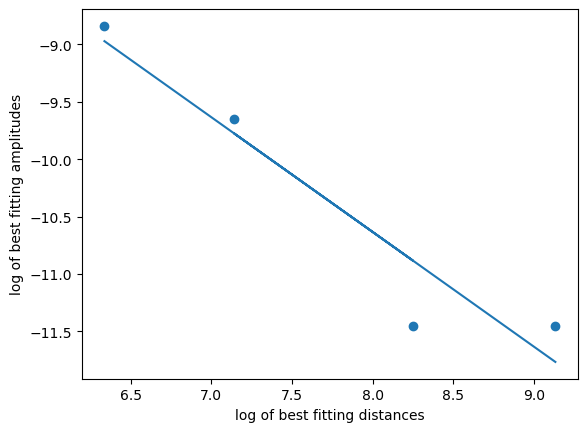

R2: 0.9005733454053632 at  ts 8830
[-11.83231699  -9.60564877 -11.65690101  -9.12393094]
[-11.99733242 -10.12190969 -11.15759905  -8.94195656]
[-0.16501543 -0.51626091  0.49930196  0.18197439]
0.5761725473379472


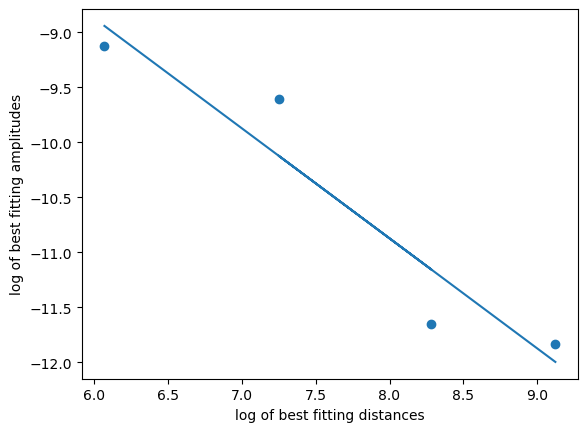

R2: 0.9159979664065867 at  ts 8830
[-11.83255423  -9.60245252 -11.65482191  -9.12487015]
[-11.97016699  -9.9805835  -11.08725482  -9.17669349]
[-0.13761276 -0.37813098  0.56756709 -0.05182334]
0.4867383691557297


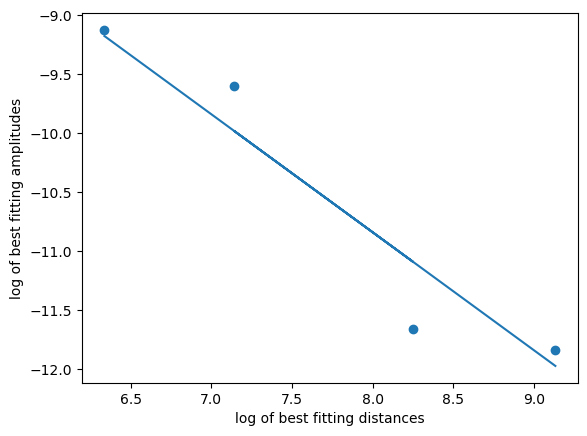

R2: 0.910169565734606 at  ts 8830
[-11.8368099   -9.60447832 -11.65324913  -9.1215708 ]
[-11.96124555  -9.84480777 -11.03388173  -9.37617309]
[-0.12443565 -0.24032946  0.61936741 -0.2546023 ]
0.5216807925045966


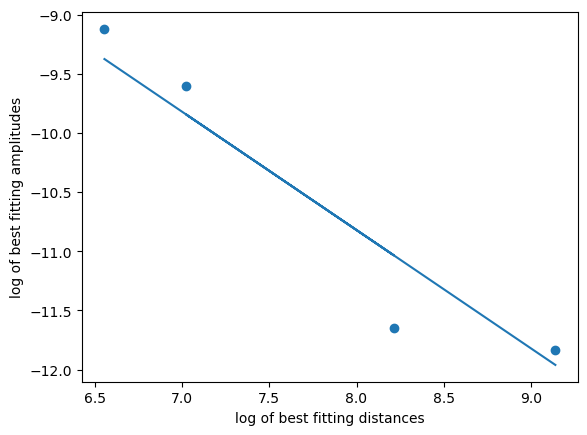

R2: 0.9094456165709492 at  ts 8840
[-11.7111637   -9.50359568 -11.53792252  -8.93785839]
[-11.86526807  -9.98984533 -11.02553469  -8.8098922 ]
[-0.15410437 -0.48624965  0.51238782  0.12796619]
0.539103505924994


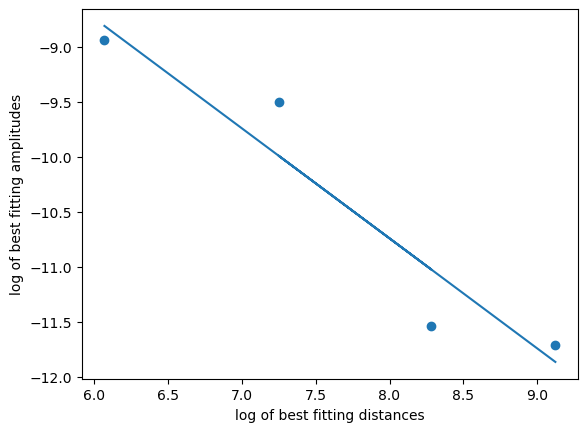

R2: 0.9006187058029221 at  ts 8840
[-11.71953922  -9.50314142 -11.5356675   -8.93790496]
[-11.86026812 -10.0461964  -11.04397415  -8.74581443]
[-0.1407289  -0.54305497  0.49169335  0.19209052]
0.5933744506603976


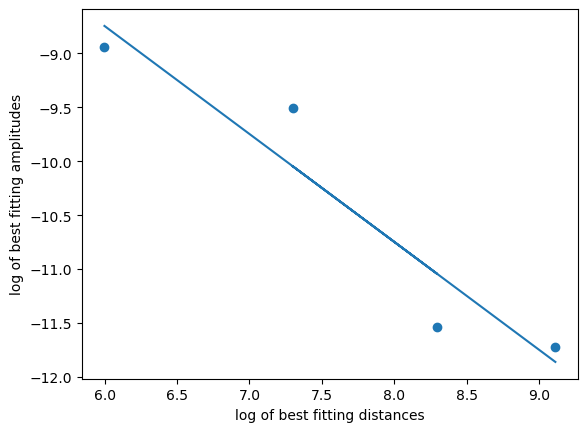

R2: 0.9170402468797239 at  ts 8840
[-11.69709253  -9.50763762 -11.54128043  -8.93538532]
[-11.83684126  -9.84725777 -10.9539291   -9.04336776]
[-0.13974874 -0.33962015  0.58735133 -0.10798244]
0.4915133480808115


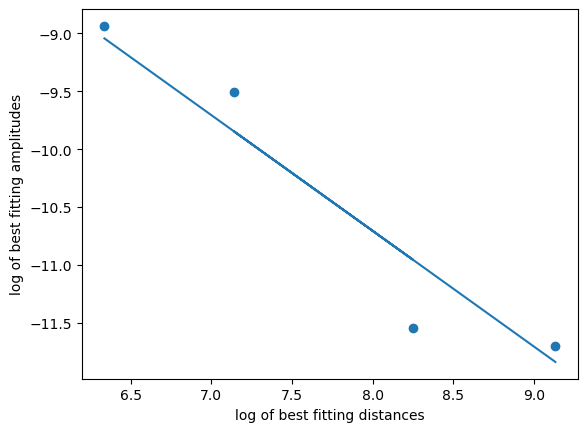

R2: 0.9042257876950507 at  ts 8840
[-11.69487129  -9.5072859  -11.54382651  -8.93607111]
[-11.82773222  -9.71129444 -10.90036839  -9.24265976]
[-0.13286093 -0.20400854  0.64345812 -0.30658865]
0.567306455637291


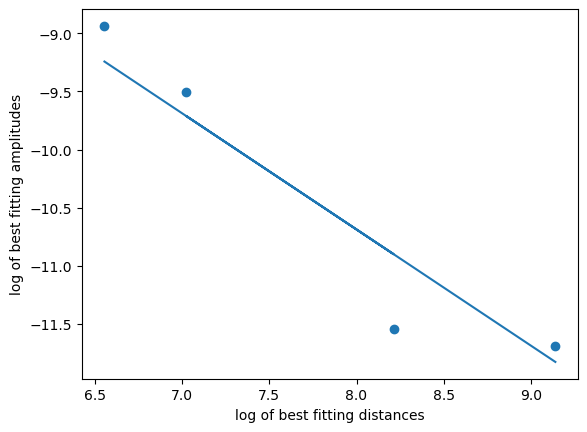

R2: 0.9141450226078738 at  ts 8870
[-11.82471151  -9.55239121 -11.61977792  -9.16639978]
[-11.9573124   -9.96772891 -11.07440023  -9.16383889]
[-0.13260089 -0.41533769  0.5453777   0.00256088]
0.48753178515537454


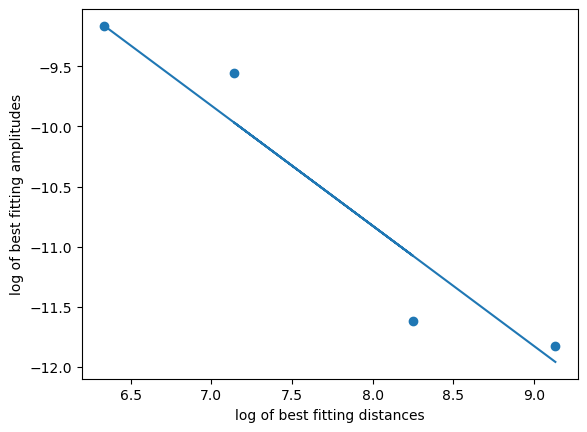

R2: 0.9128047875123471 at  ts 8870
[-11.8300399   -9.53723741 -11.62128207  -9.17098625]
[-11.94710493  -9.83066715 -11.0197411   -9.36203247]
[-0.11706502 -0.29342973  0.60154097 -0.19104622]
0.4981554288995111


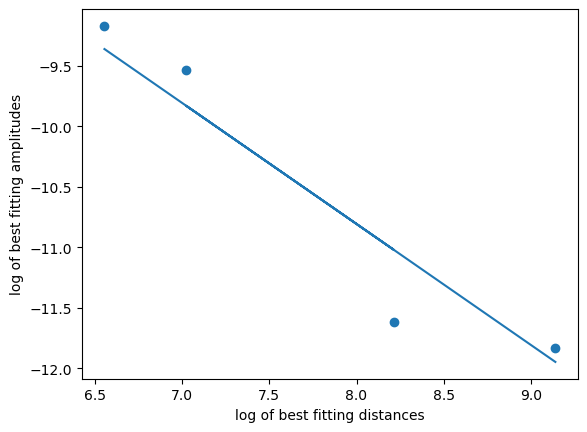

R2: 0.9028734134960672 at  ts 8870
[-11.82730802  -9.53590806 -11.62189816  -9.17005551]
[-11.93676151  -9.76061212 -10.98762375  -9.47017237]
[-0.10945349 -0.22470405  0.63427441 -0.30011686]
0.5548461398975845


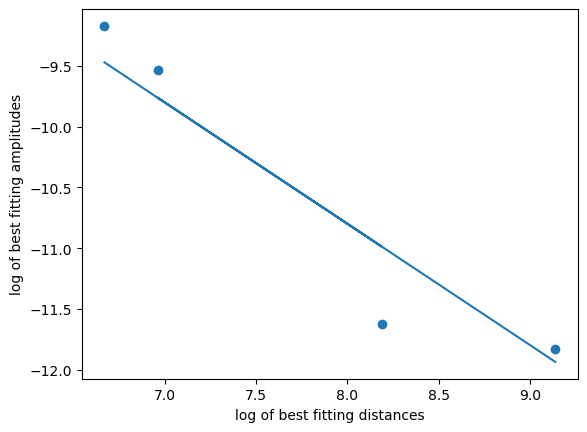

R2: 0.9064410175287165 at  ts 8880
[-11.8630122   -9.75433137 -11.79326734  -9.25776451]
[-12.08358615 -10.09400266 -11.20067398  -9.29011264]
[-0.22057395 -0.33967128  0.59259336 -0.03234814]
0.5162427443463086


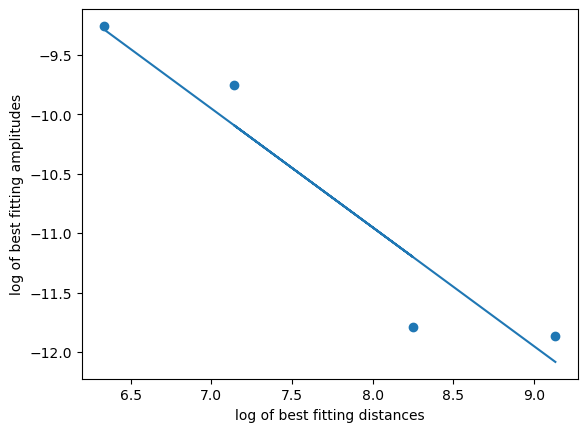

R2: 0.9014626198921385 at  ts 8890
[-11.62776927  -9.68571654 -11.6193082   -9.18250652]
[-11.94531742  -9.95573393 -11.06240525  -9.15184392]
[-0.31754815 -0.27001739  0.55690295  0.0306626 ]
0.4848273076373326


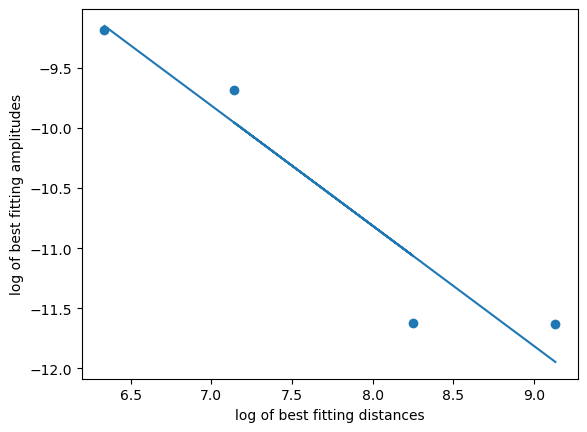

R2: 0.900273700788462 at  ts 8900
[-11.51049446  -9.65249216 -11.47599864  -9.24455438]
[-11.87810343  -9.76166565 -10.9507396   -9.29303096]
[-0.36760897 -0.10917348  0.52525904 -0.04847659]
0.42530223832813246


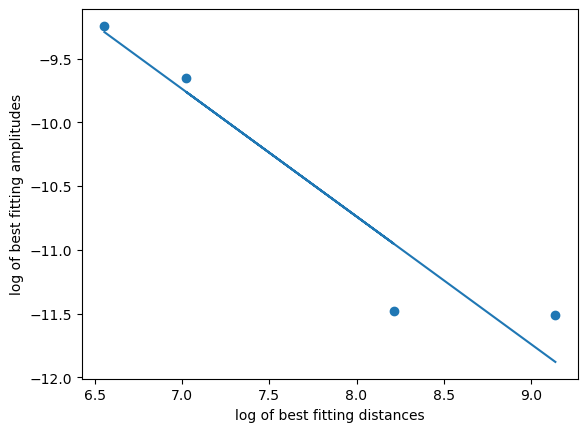

R2: 0.9024045365941036 at  ts 8940
[-11.61498623  -9.87761116 -11.45305329  -9.59988683]
[-12.04360289  -9.92716511 -11.11623906  -9.45853043]
[-0.42861667 -0.04955395  0.33681422  0.1413564 ]
0.3195932937598279


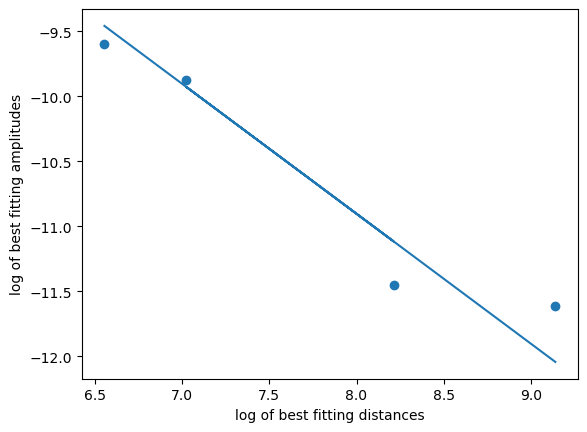

R2: 0.9032191728470366 at  ts 8940
[-11.61511519  -9.8799062  -11.4597875   -9.60039907]
[-12.03677106  -9.86062167 -11.0876333   -9.57018192]
[-0.42165587  0.01928453  0.3721542   0.03021715]
0.31757739059498835


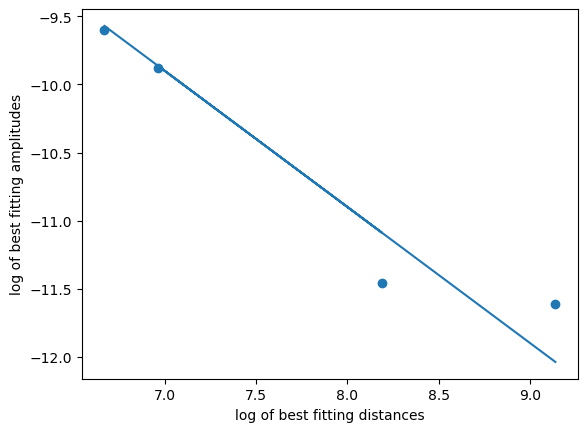

In [12]:
# Plot High R2 Values For Each Time Segment
# Uses Watson Paper Methods Constant Slope

MaxR2 = []
MaxR2x = []
MaxR2y = []
Alltimes = []
MaxR2T = []
winlength_seconds = 10
for ts in range(8000, 9200, winlength_seconds):  # Loop over 1-minute time windows

    r2best=[-9e9] # reset this for every window

    ssrbest=9e9
    
    ystreamtmp, xstreamtmp = np.nonzero(A)
    a = np.where(ystreamtmp > 0)[0]
    xstream = xstreamtmp[a]
    ystream = ystreamtmp[a]
    
    # find amplitude and distance for each station
    ampl = np.zeros((4))
    
    # loop over all the possible source locations
    for i in range(len(xstream)):
        if y[0, ystream[i]]>-7000: #this does nothing

            # vector of distances between stations and current point in meters
            dist = np.sqrt( (x[0, xstream[i]] - sta[:, 0]) ** 2 + (y[0, ystream[i]] - sta[:, 1]) ** 2)

            times = dist / beta # adjust for wave travel time
            t1samp = (ts + times) * sps # convert from time in seconds to samples
            t2samp = t1samp + winlength_seconds * sps

            # compute RMS amplitude for each station in this window
            for j in range(len(dist)):
                ampl[j] = np.array([np.sqrt(np.mean( (data_env[int(t1samp[j]):int(t2samp[j]), j])** 2))])          

            # compute the natural log of amplitudes and distances
            ampl_log = np.log(ampl)
            dist_log = np.log(dist)

            # solve with slope fixed at value of slope, m
            m=-1 # use -1 for body waves and -0.5 for surface waves
            intercept=np.mean(ampl_log - m*dist_log)
            
            yobstmp=ampl_log-intercept
            ypretmp= m*dist_log

            # Calculate SST
            SSTot = np.sum( np.square(ampl_log - np.mean(ampl_log)) )

            # Calculate SSR
            SSRes = np.sum( np.square(ampl_log - (intercept + m*dist_log) ) )


            # Compute R²
            R2 = 1 - (SSRes/SSTot)

#            if SSRes<ssrbest:
            if R2 > 0.9:
                MaxR2.append(R2)
                MaxR2x.append(x[0, xstream[i]])
                MaxR2y.append(y[0, ystream[i]]) 
                MaxR2T.append(ts)
                Alltimes.append(ts)
     
                # save some things to be able to reproduce the best fit
                ypredbest=dist_log * m + intercept
                distlogbest=dist_log
                ampllogbest=ampl_log

                r2best=R2


                if r2best > 0.9:  # Plot locations with high R2 values
                     print('R2: {} at  ts {}'.format(r2best,ts))
                
                     print(ampllogbest)
                     print(ypredbest)
                     print(ypredbest-ampllogbest)
                     print( np.sum( np.square(ampllogbest-ypredbest)))

                     plt.scatter(distlogbest,ampllogbest)
                     plt.plot(distlogbest,ypredbest)
                     plt.xlabel('log of best fitting distances')
                     plt.ylabel('log of best fitting amplitudes')
                     plt.show()

In [13]:
MaxR2xUTM = [x+715901.84 for x in MaxR2x]
MaxR2yUTM = [x+1584182.68 for x in MaxR2y]

Stationx = sta[:,0]
Stationy = sta[:,1]
StationxUTM = [x+715901.84 for x in Stationx]
StationyUTM = [x+1584182.68 for x in Stationy]

CoordsUTM = np.vstack((MaxR2xUTM, MaxR2yUTM))
StationUTM = np.vstack((StationxUTM, StationyUTM))

CoordsLatLon = utm.to_latlon(CoordsUTM[0],CoordsUTM[1], 15, northern=True)
MaxR2xLatLon = CoordsLatLon[1]
MaxR2yLatLon = CoordsLatLon[0]

StationLatLon = utm.to_latlon(StationUTM[0],StationUTM[1], 15, northern=True)
StationxLatLon = StationLatLon[1]
StationyLatLon = StationLatLon[0]

with gzip.open(r"C:\Users\jacob\Desktop\Masters Thesis Stuff\Data Files\srtm_18_10.asc.gz") as fp:
    srtm = np.loadtxt(fp, skiprows=6)
cellsize=0.00083333333333333 # this is in the header
xllcorner=-95               # this is in the header
yllcorner=10                 # this is in the header
lats = np.linspace(yllcorner+cellsize*srtm.shape[0], yllcorner, srtm.shape[0])
lons = np.linspace(xllcorner, xllcorner+cellsize*srtm.shape[1],  srtm.shape[1])

m = Basemap(projection='merc', lat_0=14.44,lon_0=-90.875, resolution="h",
            llcrnrlon=-90.95,llcrnrlat=14.39,urcrnrlon=-90.8,urcrnrlat=14.49)

# create grids and compute map projection coordinates for lon/lat grid
x, y = m(*np.meshgrid(lons, lats))

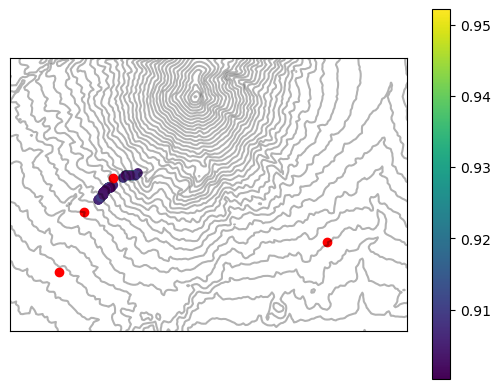

In [14]:
# Make contour plot for R2
m.contour(x, y, srtm, 40, colors="k", alpha=0.3)
x_scatter, y_scatter = m(MaxR2xLatLon, MaxR2yLatLon)
station_x_scatter, station_y_scatter = m(StationxLatLon, StationyLatLon)

a = m.scatter(x_scatter, y_scatter, c=MaxR2, cmap='viridis')
plt.colorbar(a)
m.scatter(station_x_scatter, station_y_scatter, c='r')
plt.show()

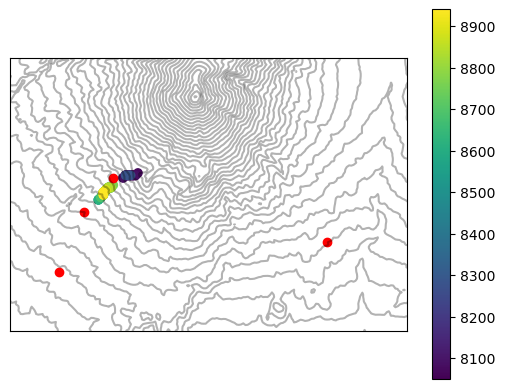

In [15]:
# Make contour plot for Time
m.contour(x, y, srtm, 40, colors="k", alpha=0.3)
x_scatter, y_scatter = m(MaxR2xLatLon, MaxR2yLatLon)
station_x_scatter, station_y_scatter = m(StationxLatLon, StationyLatLon)

a = m.scatter(x_scatter, y_scatter, c=Alltimes, cmap='viridis')
plt.colorbar(a)
m.scatter(station_x_scatter, station_y_scatter, c='r')
plt.show()